## Script para plotagem dos dados gravimétricos terrestres referentes a Bacia de Barreirinhas (dados adquiridos por Nelson Delimar - Nielsen)

In [1]:
# importando as bibliotecas necessarias para o uso do script:
# import necessary library:
import numpy as np
import pylab as py
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from scipy.interpolate import Rbf # radial basis functions technique
# to plot figures in cells:
%matplotlib inline

In [2]:
# importacao das funções externas ao anaconda:
from modules.auxiliars import inv_power_dist
#from modules.maps import plota_mapa

In [3]:
# leitura dos dados via pandas e via numpy:
# 1) dados do nielsen:
data = pd.read_table('../dados_reais/Barreirinhas/data_barreirinhas.txt')
#print data
# for Mathews PC:
#data = pd.read_table('../dados_reais/data_barreirinhas.txt')

# 2) dados de satelite (potzdam): 
lon_sat, lat_sat, gz_sat = np.loadtxt('../dados_reais/Barreirinhas/barreirinhas_satelite2.gdf', 
                                      skiprows=37, usecols=(0,1,2), unpack=True) 
# For Mathews PC:
#lon_sat, lat_sat, gz_sat = np.loadtxt('../dados_reais/barreirinhas_satelite.gdf',
#                                      skiprows=35, usecols=(0,1,3), unpack=True) 

# variaveis para usar a funcao plota mapa:
lon_sat = lon_sat -360.0  # correcao de quadrante 

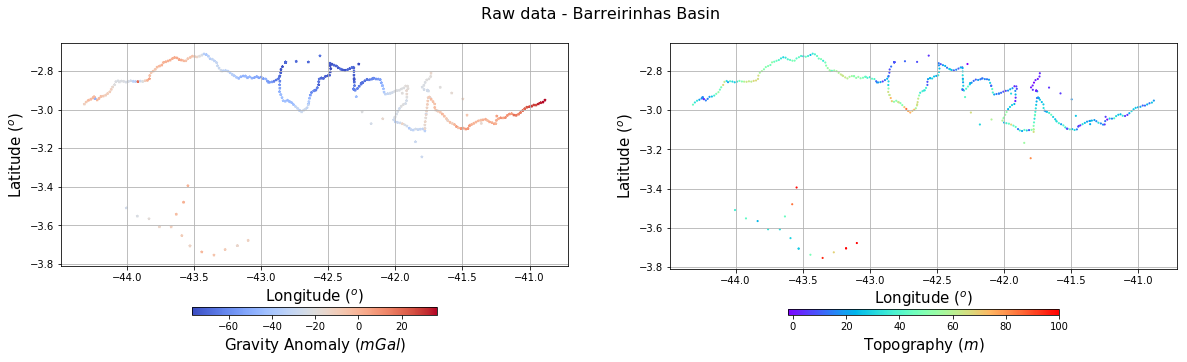

In [4]:
# leitura dos dados via pandas:
# ------------ plot the flight lines to check for the interpolation:--------#
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(20,5), facecolor='w' )

plt.subplot(1,2,1)
fig.suptitle('Raw data - Barreirinhas Basin', fontsize=16)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)
p1 = plt.scatter(data['Longitude'], data['Latitude'], s=5.0, c=data['BG (mGal)'], marker='*', cmap=plt.cm.coolwarm)
cbar = plt.colorbar(p1, aspect=30, fraction = 0.03, orientation="horizontal")
cbar.set_label('Gravity Anomaly $ (mGal) $',fontsize=15, rotation = 0)
plt.grid()
###########################################################################################################################

plt.subplot(1,2,2)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)

p2  = plt.scatter(data['Longitude'], data['Latitude'], s=5.0, c=data['H (m)'], marker='.', cmap=plt.cm.rainbow)
cbar= plt.colorbar(p2, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Topography $ (m) $',fontsize=15, rotation = 0)
plt.grid()
plt.show()

##  <center> Remocao de outliers dos dados: <center> 

In [5]:
# Etapa 01: seleção do range indesejavel:
df = data.loc[ (data['Longitude'] < -43.0) & (data['Latitude'] < -3.2 ) ]

In [6]:
# remover as linhas armazenadas no array indices:
df = data.drop(df.index.values)

In [7]:
# por em ordem em função da longitude(coluna 2)
ds = df.sort_values(by=['Longitude'], ascending=True)

In [8]:
# remove valores repetidos em diferentes linhas (Mathews descobriu como fazer remoçoes de duplicatas via pandas!:
ds.drop_duplicates( ['Longitude','Latitude'], keep='first', inplace=True )

In [9]:
# salvando arquivo para georeferenciamento (for Rod):
#ds.to_csv('../../dados_reais/Barreirinhas/caminhamento.csv', sep = ' ', encoding='utf-8')

# salvando arquivo para georeferenciamento for Mathews:
ds.to_csv('../dados_reais/Barreirinhas/caminhamento.csv', sep = ' ', encoding='utf-8')

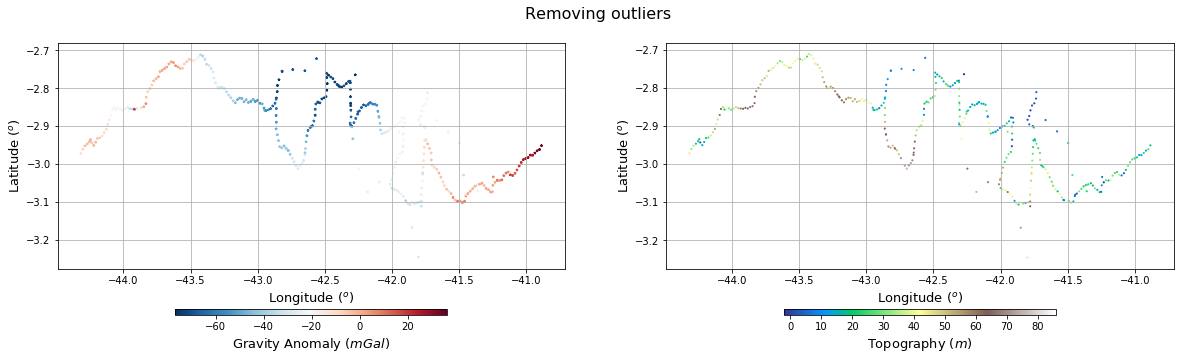

In [10]:
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(20,5), facecolor='w')
plt.subplot(1,2,1)

fig.suptitle('Removing outliers', fontsize=16)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)
p1 = plt.scatter(ds['Longitude'], ds['Latitude'], s=5.0, c=ds['BG (mGal)'], marker='*', cmap='RdBu_r')
cbar = plt.colorbar(p1, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Gravity Anomaly $ (mGal) $',fontsize=13, rotation = 0)
plt.grid()
###########################################################################################################################

plt.subplot(1,2,2)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)

p2  = plt.scatter(ds['Longitude'], ds['Latitude'], s=5.0, c=ds['H (m)'], marker='.', cmap='terrain')
cbar= plt.colorbar(p2, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Topography $ (m) $',fontsize=13, rotation = 0)
plt.grid()
plt.show()

In [11]:
## processameintu: Definicao dos novos ranges dos dados:
# Etapa 01: seleção do range indesejavel:
ds2 = ds.loc[ (ds['Longitude'] < -41.5) & (ds['Longitude'] > -44.0 ) ]

In [12]:
ds2

,Station,Longitude,Latitude,X (m),Y (m),H (m),G (mGal),FA (mGal),BG (mGal),N (m)
92,M123,-43.989176,-2.854281,612346.0,9684464.0,35.38,978013.926,-19.810,-23.770,-23.63
93,M124,-43.971398,-2.850680,614323.0,9684860.0,47.83,978010.074,-19.780,-25.140,-23.59
94,M125,-43.952980,-2.853699,616370.0,9684524.0,51.37,978001.866,-26.930,-32.680,-23.52
95,M126,-43.936180,-2.854481,618237.0,9684436.0,59.75,977998.826,-27.390,-34.080,-23.47
96,M127,-43.918157,-2.855169,620240.0,9684358.0,64.21,978052.233,27.390,20.200,-23.40
97,M128,-43.900481,-2.852823,622205.0,9684616.0,62.70,978004.469,-20.820,-27.840,-23.34
98,M129,-43.882685,-2.854410,624183.0,9684438.0,61.34,978012.129,-13.600,-20.460,-23.28
99,M130,-43.865288,-2.850549,626118.0,9684863.0,66.94,978020.842,-3.120,-10.610,-23.22
100,M131,-43.847726,-2.848493,628070.0,9685089.0,66.63,978031.618,7.580,0.120,-23.17
101,M132,-43.832924,-2.840501,629716.0,9685971.0,65.37,978036.903,12.550,5.230,-23.13


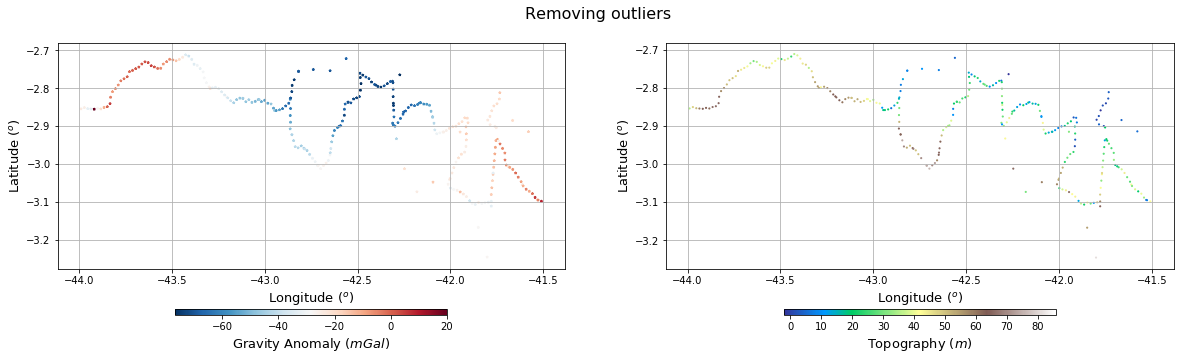

In [13]:
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(20,5), facecolor='w')
plt.subplot(1,2,1)

fig.suptitle('Removing outliers', fontsize=16)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)
p1 = plt.scatter(ds2['Longitude'], ds2['Latitude'], s=5.0, c=ds2['BG (mGal)'], marker='*', cmap='RdBu_r')
cbar = plt.colorbar(p1, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Gravity Anomaly $ (mGal) $',fontsize=13, rotation = 0)
plt.grid()
###########################################################################################################################

plt.subplot(1,2,2)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)

p2  = plt.scatter(ds2['Longitude'], ds2['Latitude'], s=5.0, c=ds2['H (m)'], marker='.', cmap='terrain')
cbar= plt.colorbar(p2, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Topography $ (m) $',fontsize=13, rotation = 0)
plt.grid()
plt.show()

In [14]:
# associando os dados as variaveis mnemonicas para calculos posteriores:
lon  = np.array(ds2['Longitude'])
lat  = np.array(ds2['Latitude'])
utmx = np.array(ds2['X (m)'])
utmy = np.array(ds2['Y (m)']) 
elev = np.array(ds2['H (m)']) 
gz   = np.array(ds2['BG (mGal)'])

In [18]:
#ajustando o perfil a partir dos dados terrestres:
# Construção da matriz A (chamada de matriz de sensiblidade)
A = np.zeros( (np.size(lon),2) )

#print np.shape(A)
A[:,0] = lon
A[:,1] = 1.0

# Equação de minimos quadrados para ajustar o perfil que passa mais proximo aos pontos medidos:
### $$\mathbf{p} = (A^TA)^{-1}A^Ty$$

# Ou ainda:
### $$ (A^TA)~\mathbf{p} = A^T y $$

In [19]:
# ------ minimos quadrados lineares --------:
# Transposto:
AT = np.transpose(A)

# Multiplicação de MAtrizes (Aproximacao da Hessiana): 
ATA = np.matmul(AT,A)
# construcao do lado direito do sistema (ATy):
B = np.matmul(AT,lat)

# Resolvendo o sistema linear montado via internal function linalg.solve():
p = np.linalg.solve(ATA, B)

# gerando valores de lat do perfil: y=ax+b:
y = p[0]*lon + p[1] # sao os valores de latitude para o perfil.

In [20]:
# interpolação pelo inverso da potencia da distancia para computar a anomalia da gravidade no perfil ajustado:
gzi = inv_power_dist(lon, lat, gz, lon, y, 2.0)

In [21]:
# interpolacao da topografia para anexar ao arquivo de dados em perfil:
elevi = inv_power_dist(lon, lat, elev, lon, y, 2.0)

## <center> ------ Plot the raw data and the interpolated data in the profile ----------: <center>

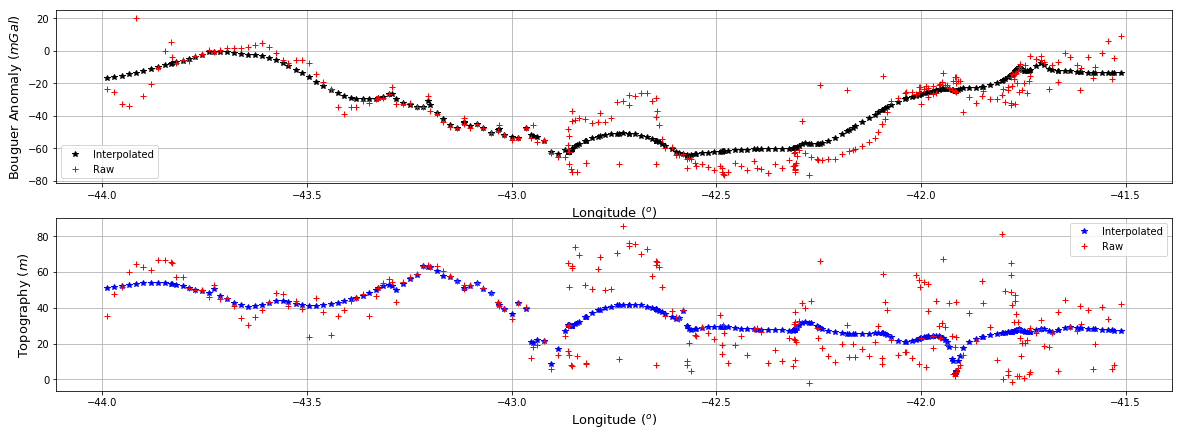

In [22]:
# ------------ set figure size: ------------------------------------------#
plt.close('all')

#### ATENÇÃO À ESCALA DAS FIGURAS!!!!! #########
fig = plt.figure(figsize=(20,7), facecolor='w')
plt.subplot(2,1,1)

plt.plot(lon,gzi,'*k', label='Interpolated')
plt.plot(lon,gz,'+r', label='Raw')
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Bouguer Anomaly $(mGal)$', fontsize = 13)
plt.legend()
plt.grid()
###########################################################################################################################

plt.subplot(2,1,2)
plt.plot(lon,elevi,'*b', label='Interpolated')
plt.plot(lon,elev,'+r', label='Raw')
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Topography $(m)$', fontsize = 13)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# plot dos dados:
def drawstates(ax, shapefile='../dados_reais/brazil_shapefile/BRA_adm0.shp'):
        shp = m.readshapefile(shapefile, 'states', drawbounds=True)
        for nshape, seg in enumerate(m.states):
            poly = Polygon(seg, facecolor='0.75', edgecolor='k')
            ax.add_patch(poly)


### Coordenadas x y da projeção cartográfica

In [23]:
# calculo da area onde serao plotadas as imagens:
lon_min = np.min(lon_sat)
lon_max = np.max(lon_sat)
lat_min = np.min(lat_sat)
lat_max = np.max(lat_sat)
area = [lon_min, lon_max, lat_min, lat_max]
print (area)

[-45.0, -40.0, -4.0, -2.0]


## Plot gravity anomaly into georeferenced map using basemap function: 

/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-5009377.085697311,-442661.6382297501,-4452779.631730943,-221194.07716771573&bboxSR=3395&imageSR=3395&size=500,198&dpi=96&format=png32&f=image


/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: M

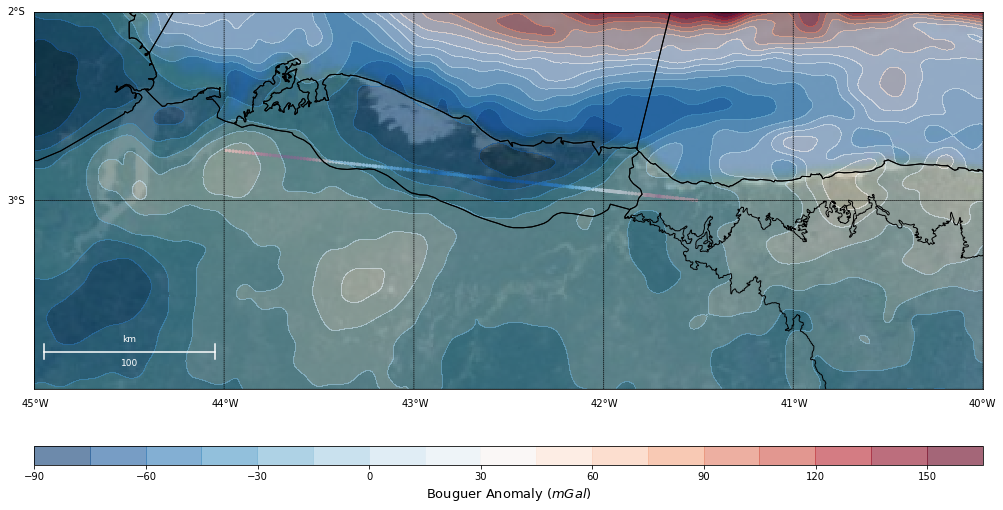

In [24]:
#%matplotlib inline
#%%python2
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(17,9), facecolor='w')

# ------------------------- Define the center of the map -----------------------------------#  
lon0 = 0.5*(area[0] + area[1])
lat0 = 0.5*(area[2] + area[3])

# ------- use basemap function to create the plot : ---------# 
m = Basemap(llcrnrlon=area[0],llcrnrlat=area[2],
            urcrnrlon=area[1],urcrnrlat=-2., 
            resolution='l',projection='tmerc', 
            lon_0=lon0, lat_0=lat0,epsg=3395)


#----------Drawing Lat Long: -------------#
m.drawmeridians(range(0,360,1), labels=[0, 1, 0, 1], latmax=area[1])
m.drawparallels(range(-90,90,1), labels=[1, 0, 1, 0],latmax=area[3])
m.drawmapscale(-44.5, -3.8, lon_max, lat_max, 100, 'simple', fontcolor = 'w')

#------------------Loading Shapefiles---------------#
#m.readshapefile('brazil_shapefile/BRA_adm0', 'Brasil', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/MatoGrossodoSul', 'MatoGrossodoSul', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/Parana', 'Parana', drawbounds=True, linewidth=1)
m.readshapefile('../dados_reais/shapeFiles/bacias/Limite_das_Bacias_Sedimentares', 'Limite_das_Bacias_Sedimentares', 
                drawbounds=True, linewidth=1)

#--------------Background satellite image options-----------#

#m.shadedrelief(scale=1)
#m.etopo(scale=2)
#m.bluemarble(scale=0.5)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 500, verbose= True)
#m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, ypixels= 500, verbose= True)

# TODO: make a accurate scale for the map
#---------------- Scaling the map---------------#
#m.drawmapscale(lon0, area[0], area[1], area[3], 250, barstyle='fancy')


# ---- Plot the profile data over the map as a scatter plot:
k = m.scatter(lon, y, s=25.0, c=gzi, marker='.', cmap=plt.cm.RdBu_r, latlon=True)

#----- colorbar specifications -----:
cbar.set_label('Bouguer Anomaly $ (mGal) $',fontsize=12, rotation=90, )

#------------------Anomaly map------------------#
k = m.contourf(lon_sat, lat_sat, gz_sat, 20, tri=True, cmap='RdBu_r', 
               latlon=True, alpha=0.6, vmin=min(gz_sat), vmax=max(gz_sat) )

#----- colorbar specifications -----:
cbar = m.colorbar(k, location='bottom', size="5%", pad="15%")
cbar.set_label('Bouguer Anomaly $ (mGal) $',fontsize=13, rotation=0)
#-------------Add Title-----------------------#
#plt.title('S ', fontsize=16, pad='10')
#plt.savefig('barreirinhas_map.png', dpi=600, transparent=True, bbox_inches='tight')
#plt.savefig('barreirinhas_map.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-5009377.085697311,-442661.6382297501,-4452779.631730943,-221194.07716771573&bboxSR=3395&imageSR=3395&size=500,198&dpi=96&format=png32&f=image


/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rodbijani/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


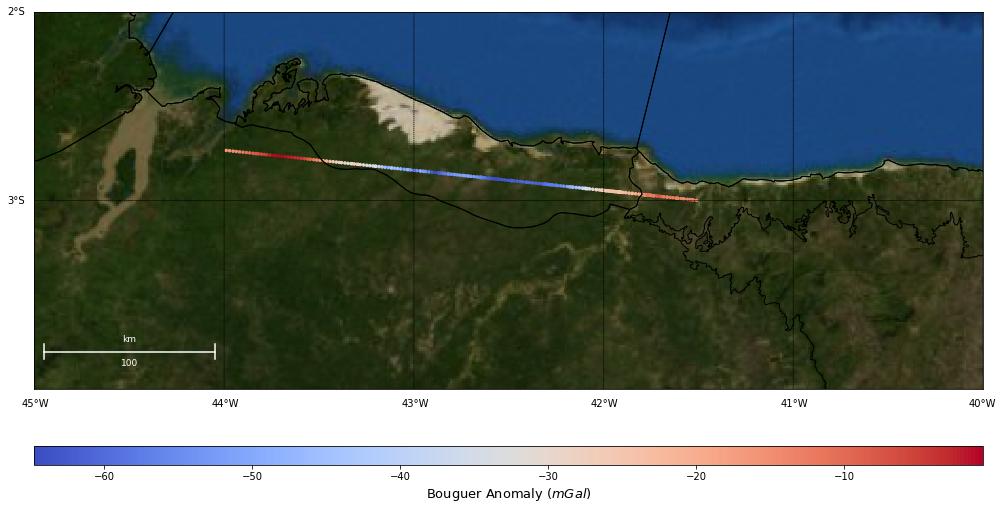

In [25]:
# ------------ set figure size: ------------------------------------------#
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(17,9))

# ------------------------- Define the center of the map -----------------------------------#  
lon0 = 0.5*(area[0] + area[1])
lat0 = 0.5*(area[2] + area[3])

# ------- use basemap function to create the plot : ---------# 
m = Basemap(llcrnrlon=area[0],llcrnrlat=area[2],
            urcrnrlon=area[1],urcrnrlat=-2., 
            resolution='l',projection='tmerc', 
            lon_0=lon0, lat_0=lat0,epsg=3395)


#----------Drawing Lat Long: -------------#
m.drawmeridians(range(0,360,1), labels=[0, 1, 0, 1], latmax=area[1])
m.drawparallels(range(-90,90,1), labels=[1, 0, 1, 0],latmax=area[3])
m.drawmapscale(-44.5, -3.8, lon_max, lat_max, 100, 'simple', fontcolor = 'w')

#------------------Loading Shapefiles---------------#
#m.readshapefile('brazil_shapefile/BRA_adm0', 'Brasil', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/MatoGrossodoSul', 'MatoGrossodoSul', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/Parana', 'Parana', drawbounds=True, linewidth=1)
m.readshapefile('../dados_reais/shapeFiles/bacias/Limite_das_Bacias_Sedimentares', 'Limite_das_Bacias_Sedimentares', 
                drawbounds=True, linewidth=1)
#--------------Background satellite image options-----------#

#m.shadedrelief(scale=1)
#m.etopo(scale=2)
#m.bluemarble(scale=0.5)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 500, verbose= True)
#m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, ypixels= 500, verbose= True)

# TODO: make a accurate scale for the map
#---------------- Scaling the map---------------#
#m.drawmapscale(lon0, area[0], area[1], area[3], 250, barstyle='fancy')


# ---- Plot the profile data over the map as a scatter plot:
k = m.scatter(lon, y, s=25.0, c=gzi, marker='.', cmap=plt.cm.coolwarm, latlon=True)
#k = m.scatter(lon, lat, s=25.0, c=gz, marker='.', cmap=plt.cm.coolwarm, latlon=True)

#----- colorbar specifications -----:
cbar.set_label('Terrestrial Bouguer $ (mGal) $',fontsize=12, rotation=90, )

#------------------Anomaly map------------------#
#k = m.contourf(lon_sat, lat_sat, gz_sat, 20, tri=True, cmap=plt.cm.coolwarm, 
#               latlon=True, alpha=0.5, vmin=min(gz_sat), vmax=max(gz_sat) )

#----- colorbar specifications -----:
cbar = m.colorbar(k, location='bottom', size="5%", pad="15%")
cbar.set_label('Bouguer Anomaly $ (mGal) $',fontsize=13, rotation=0)
#-------------Add Title-----------------------#
#plt.title('Gravity study of Barreirinhas Basin', fontsize=16, pad='10')
#plt.savefig('barreirinhas_map2.png', dpi=600, transparent=True, bbox_inches='tight')
#plt.savefig('barreirinhas_map2.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [26]:
# converter lat lon do perfil em utmx e utmy via basemap:
utmx,utmy = m(lon, y)

In [27]:
# Salvando arquivo para georeferenciamento no mapa geológico de barreirinhas:
g = {"utmx": utmx, 'utmy':utmy}
type(g)
geo_ref = pd.DataFrame( data=g )

# salvando arquivo para georeferenciamento for ROD:
geo_ref.to_csv('../dados_reais/Barreirinhas/xy_perfil.txt', sep = ' ', encoding='utf-8', index=False)

# salvando arquivo para georeferenciamento for Mathews:
#geo_ref.to_csv('../dados_reais/Barreirinhas/caminhamento_perfil.csv', sep = ' ', encoding='utf-8')

## <center> Salvando arquivo com os dados em perfil: <center>

In [28]:
# Salvando arquivo para georeferenciamento no mapa geológico de barreirinhas:
names = ['Utmx', 'Utmy', 'H(m)', 'mGal']
g = {"utmx": utmx, 'utmy':utmy, "H(m)":elevi, "mGal": gzi}
geo_ref = pd.DataFrame(g)
#print geo_ref

### TODO: verificar o por que o pandas coloca as colunas por ordem alfabética #####

# salvando arquivo para georeferenciamento for ROD:
geo_ref.to_csv('../dados_reais/Barreirinhas/barreirinhas_perfil.txt', sep = ' ', encoding='utf-8', index=False)

# salvando arquivo para georeferenciamento for Mathews:
#geo_ref.to_csv('../dados_reais/Barreirinhas/barreirinhas_perfil.txt', sep = ' ', encoding='utf-8', index=False)

## <center> End of the script ! <center>